# Part I : Quel(le) data scientist êtes-vous ?
## Contexte de l’analyse

Elu métier le plus sexy par la Harvard Business Review en octobre 2012, le data scientist représente un profil rare qui exige de nombreuses compétences.

A partir d'un dataset Aquila, vous réaliserez :
- un clustering non supervisé afin d'identifier 2 groupes de profils techniques distinctes
- une prédiction des profils dont le métier n'est pas labellisé


## Données
data.csv contient 6 variables : 
    - 'Entreprise' correspond à une liste d'entreprises fictive
    - 'Metier' correspond au métier parmi data scientist, lead data scientist, data engineer et data architecte
    - 'Technologies' correspond aux compétences maîtrisées par le profil
    - 'Diplome' correspond à son niveau scolaire (Bac, Master, PhD,...)
    - 'Experience' correspond au nombre d'années d'expériences
    - 'Ville' correspond au lieu de travail
    


## Répondez aux questions 

Bonne chance!

In [1]:
# Import des libraries classique (numpy, pandas, ...)
import os
import sys
import pandas as pd
import numpy as np
import re
from IPython.display import clear_output, display
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.close('all')

In [2]:
# Reload des modules automatiquement, pas nécessaire pour faire tourner le nb
%load_ext autoreload
%autoreload 2

### 1) Importer le tableau de données dans un dataframe 

In [3]:
# Import du dataframe "data.csv"
df = pd.read_csv("../data/data.csv", sep = ",", dtype = {'Enterprise': "str",
                                                         'Metier': "str",
                                                         'Technologies': 'str',
                                                         "Diplome" : "str",
                                                         "Experience"  : "str",
                                                         "Ville" : "str"})
df.Experience = df.Experience.str.replace(',', '.', regex = False).astype(float)
df.head()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.0,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.0,Marseille
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.0,Nantes
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.5,Marseille
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,NaN,Bordeaux


### 2) Combien y a t-il d'observations dans ce dataset? Y a t-il des valeurs manquantes? 

In [4]:
print("il y a ",df.shape[0], " obserbations dans le dataset.")
print("il y a ",df.isna().sum().sum(), " valeurs manquantes.")

il y a  9582  obserbations dans le dataset.
il y a  130  valeurs manquantes.


### 3) Réaliser l'imputation des valeurs manquantes pour la variable "Experience" avec : 
- la valeur médiane pour les data scientists
- la valeur moyenne pour les data engineers

In [5]:
experience_median_datascientist = df.Experience[df.Metier == "Data scientist"].\
median(axis = 0, skipna = True)
experience_median_dataengineer = df.Experience[df.Metier == "Data engineer"].\
median(axis = 0, skipna = True)

filter_datascientist = df.Experience[df.Metier == "Data scientist"].isna()
filter_datascientist = filter_datascientist[filter_datascientist].index
filter_dataengineer = df.Experience[df.Metier == "Data engineer"].isna()
filter_dataengineer = filter_dataengineer[filter_dataengineer].index

df.loc[filter_datascientist,"Experience"] = experience_median_datascientist
df.loc[filter_dataengineer,"Experience"] = experience_median_dataengineer

### 4) Combien d'années d'expériences ont, en moyenne, chacun des profils : le data scientist, le lead data scientist et le data engineer en moyenne?

In [6]:
mean_experience_by_metier = df.groupby("Metier").agg({'Experience':'mean'})
mean_experience_by_metier

,Experience
Metier,
Data architecte,3.000476
Data engineer,2.980827
Data scientist,2.241268
Lead data scientist,3.965261


### 5) Faire la représentation graphique de votre choix afin de comparer le nombre moyen d'années d'expériences pour chaque métier

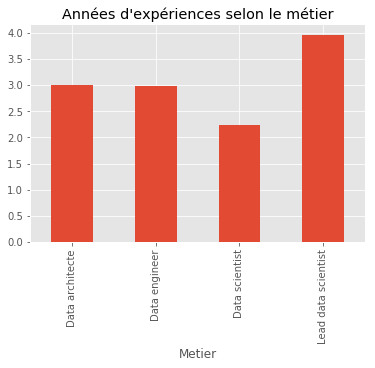

In [7]:
mean_experience_by_metier.plot.bar(title = "Années d'expériences selon le métier",
                                   legend = False)
plt.show()

### 6) Transformer la variable continue 'Experience' en une nouvelle variable catégorielle 'Exp_label' à 4 modalités: débutant, confirmé, avancé et expert
- Veuillez expliquer votre choix du règle de transformation.  

Pour répondre à cette question, je partirais de deux hypothèses : 

1. La nouvelle variable **Exp_label** représente le niveau de qualification des profils du dataset. J'affirme que le niveau de qualification dépend directement du nombre d'**années d'experiences** et **JAMAIS du diplôme**.
2. Les 4 populations [_débutant, confirmé, avancé, expert_] ne peuvent pas être de tailles égales. Il ne peut exister autant d'experts que de débutants. J'élimine donc un découpage basé sur les quartiles de la variable expérience. Néanmoins, par expérience, on peut avoir une idée de la distribution de la population : 
 * Il n'existe qu'un petit nombre d'experts. Fixons ce chiffre de manière arbitraire à 10%
 * Il existe grosso modo autant de débutants que de confirmés
 * Il existe à priori un peu moins d'avancés que de débutants. On affirme de manière arbitraire qu'il existe moitié moins d'avancés que de débutants.

Le nouvelle variable **Exp_label** est donc construite de la manière suivante : 
 * **Experts** : Les individus avec un nombre d'années d'expériences situé dans le 1er décile (le top 10%), p90
 * **Avancés** : le top 20% de la tranche 0-90%, pi80
 * **Confirmés** : la tranche 20-60% de la tranche 0-90%, pi60
 * **Débutants** : la tranche 0-60% de la tranche 0-90%, p0

 Afin d'éviter toute erreur grossière, on peut au préalable visualiser le boxplot de la variable _Experience_ :

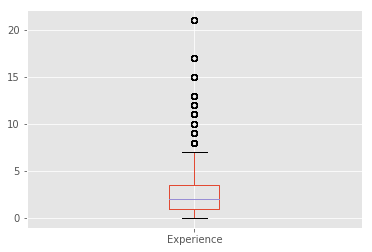

In [8]:
df.Experience.plot.box()
plt.show()

La distribution de la nouvelle variable Exp_label ne correspond pas à mon hypothèse de répartition sur laquelle je me suis basée. Ceci s'explique par le fait que la variable 'Experience' contenant peu de valeurs distinctes.

In [9]:
# Calcul des bornes
p90 = df.Experience.quantile(0.9)
p0 = df.Experience.quantile(0)
kept_idx = np.where(df.Experience < p90)[0]
Experience090 = df.Experience[kept_idx]
pi80 = Experience090.quantile(0.8)
pi60 = Experience090.quantile(0.6)

# Affectation
df["Exp_label"] = "debutant"
df.loc[df.Experience>=pi60, "Exp_label"] = "confirme"
df.loc[df.Experience>=pi80, "Exp_label"] = "avance"
df.loc[df.Experience>=p90, "Exp_label"] = "expert"
df.Exp_label.value_counts()

debutant    4884
avance      1977
confirme    1619
expert      1102
Name: Exp_label, dtype: int64

### 7) Quelles sont les 5 technologies les plus utilisées? Faites un graphique

In [10]:
# Construction de la statistique
series_of_technologies = []
for idx,row in df.iterrows():
    r = row["Technologies"].split("/")
    series_of_technologies += r 
top5_technologies = (pd.Series(series_of_technologies)).value_counts()[:5]

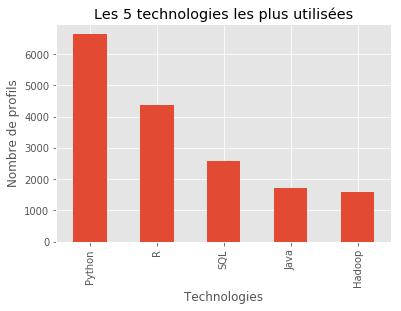

Les 5 technologies les plus uilisées sont Python, R, SQL, Java, Hadoop


In [11]:
# Affichage du graphique
top5_technologies.plot.bar(title = "Les 5 technologies les plus utilisées",
                           legend = False)
plt.xlabel('Technologies')
plt.ylabel('Nombre de profils')
plt.show()
print("Les 5 technologies les plus uilisées sont",", ".\
      join(top5_technologies.index.values.tolist()))

### 8) Réaliser une méthode de clustering non supervisée de votre choix pour faire apparaître 2 clusters que vous jugerez pertinents. Donnez les caractéristiques de chacun des clusters.
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

## Pré-processing
On construit dans un premier temps, le dataframe qui nous servira pour le clustering. Dans un souci de performance et d'intréprabilité certaines variables vont être modifiées afin de réduire leur dimension. D'autres jugées non pertinentes seront exlues.

### Pré-processing, transformation de la variable 'Technologies'
On cherche à réduire la dimension de la variable technologies en ne sélectionnant que les tecnhlogies jugées les plus pertinentes. Pour ce faire, on choisit arbitrairement de ne sélectionner que les top n technologies tel que 75% des individus aient au moins une de ces n technologies. Il s'avère après analyse que les dites n technlogies sont **'Python' 'R' 'SQL' 'Java' 'Hadoop' 'Excel' 'C++' 'Spark'**.
Le data frame **tech_df_to_add** contient les nouvelles features relatives à la variable *Technologies*

In [12]:
def compute_profil_w_pop_tech(df, threshold, selected_technologies):
    
    L = []
    
    for idx,row in df.iterrows():
        r = np.array(row["Technologies"].split("/"))
        intersection_size = len(np.intersect1d(selected_technologies,r))
        L.append(intersection_size>threshold)
        
    return L

In [13]:
technologies_rk = (pd.Series(series_of_technologies).value_counts() / len(series_of_technologies))
selected_technologies = technologies_rk.cumsum() < 0.5
selected_technologies = selected_technologies[selected_technologies].index.values
threshold = 1
profil_with_pop_technologies_bool = np.array(compute_profil_w_pop_tech(df,
                                                                       threshold,
                                                                       selected_technologies))
couverture = profil_with_pop_technologies_bool.sum()/len(df)
print("Nombre de tech :", len(selected_technologies))
print("Couverture ", "(profil avec au moins ", threshold, " tech) : ", couverture)
print("Les technologies retenues : ", selected_technologies)

Nombre de tech : 8
Couverture  (profil avec au moins  1  tech) :  0.7478605719056565
Les technologies retenues :  ['Python' 'R' 'SQL' 'Java' 'Hadoop' 'Excel' 'C++' 'Spark']


In [14]:
def compute_tech_df_to_add(df, selected_technologies):
    
    technologies_df = pd.DataFrame()
    compteur = 1
    
    for idx,row in df.iterrows():
        clear_output(wait=True)
        compteur = compteur + 1
        print("Progression : ", 100 * round((compteur/len(df)),2), "%")
        r = np.array(row["Technologies"].split("/"))
        intersection = np.intersect1d(selected_technologies,r)
        solution = (np.in1d(selected_technologies, intersection)).astype(int)
        arow = pd.Series(solution, index = selected_technologies, name = idx)
        technologies_df = technologies_df.append(arow)
        
    technologies_df = technologies_df.astype(int)
    
    return technologies_df

In [15]:
# ATTENTION!!
# Un peu lent, performance pas géniale, sûrement améliorable, mais je fais ça en vitesse
tech_df_to_add = compute_tech_df_to_add(df, selected_technologies)

Progression :  100.0 %


### Pré-processing, transformation de la variable 'Entreprise'
La distribution de la variable _Entreprise_ est telle qu'on ne peut la résumer avec un nombre relativement faible de dummy variables. De plus, étant donné le sujet, i.e. des profils dans les métiers de la data, il semble raisonnable de penser que peu d'entreprises ne se concentrent que sur un métier particulier. Cela aurait été différent s'il existait dans le dataframe des métiers très différent (par ex : Coiffeur, Data scientist, Comptable). Autrement dit, il est légitime de penser que le pouvoir discriminant de cette variable soit relativement faible dans ce cas précis. Par conséquent, **j'exclus cette variable de l'étude**.

In [16]:
entreprise_rk = df.Entreprise.value_counts() / len(df)
selected_entreprise = entreprise_rk.cumsum() < 0.75
selected_entreprise = selected_entreprise[selected_entreprise].index.values
len(selected_entreprise)

416

### Pré-processing, transformation de la variable 'Ville'
Tout comme dans le cas de la variable _Technologies_, on cherche à réduire la dimension de cette variable. En suivant le même procédé, on choisit ne sélectionner que les dummy variables correspondant aux villes **'Paris' 'Lyon' 'Marseille' 'Toulouse' 'Lille'**. Malgré le pouvoir à priori relativement faible de cette variable, on décide de la garder dans l'étude. Le data frame **ville_df_to_add** contient les nouvelles features relatives à la variable _Ville_

In [17]:
ville_rk = df.Ville.value_counts() / len(df)
selected_ville = ville_rk.cumsum() < 0.75
selected_ville = selected_ville[selected_ville].index.values
print("Nombre de villes retenues : ", len(selected_ville))
print("Villes retenues : ", selected_ville)

Nombre de villes retenues :  5
Villes retenues :  ['Paris' 'Lyon' 'Marseille' 'Toulouse' 'Lille']


In [18]:
def compute_ville_df_to_add(df, selected_ville):
    
    villes_df = pd.DataFrame()
    compteur = 1
    
    for idx,row in df.iterrows():
        clear_output(wait = True)
        compteur = compteur + 1
        print("Progression : ", 100 * round((compteur/len(df)),2), "%")
        r = row["Ville"]
        solution = (np.in1d(selected_ville, r)).astype(int)
        arow = pd.Series(solution, index = selected_ville, name = idx)
        villes_df = villes_df.append(arow)
        
    villes_df = villes_df.astype(int)
    
    return villes_df

In [19]:
# ATTENTION!!
# Un peu lent, performance pas géniale, sûrement améliorable, mais je fais ça en vitesse
ville_df_to_add = compute_ville_df_to_add(df, selected_ville)

Progression :  100.0 %


### Pré-processing, transformation des variables 'Metier', 'Diplome', 'Exp_label'
Simple conversion des variables en dummy variables. **REMARQUE IMPORTANTE :** la variable **'Métier'** étant à priori très corrélée avec les deux clusters qu'on recherche, il est envisageable de **la supprimer**. Toutefois, je préfère opter pour une approche "naïve" sans à priori. Je décide donc de la garder.

In [20]:
metier_diplome_experience_df_to_add = pd.get_dummies(df[["Metier", "Diplome", "Exp_label"]])

### Assemblage
On rassemble les features nouvellement créées dans un dataframe **df_for_clustering**

In [21]:
all_dataframes = (metier_diplome_experience_df_to_add,
                  ville_df_to_add,
                  tech_df_to_add)
df_for_clustering = pd.concat(all_dataframes, axis = 1)
df_for_clustering.head()

,Metier_Data architecte,Metier_Data engineer,Metier_Data scientist,Metier_Lead data scientist,Diplome_Bachelor,Diplome_Master,Diplome_No diploma,Diplome_Phd,Exp_label_avance,Exp_label_confirme,...,Paris,Toulouse,C++,Excel,Hadoop,Java,Python,R,SQL,Spark
0,0,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
2,0,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,1,1,1,0
3,0,0,1,0,0,1,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
4,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0


## Clustering
Afin de répondre au test, **j'ai décidé de développer une petite implémentation de l'algorithme de clustering 'kmodes'**. L'url du repo associé est : https://github.com/hansglick/kmodes .
Quelques remarques à propos de l'implémentation :
 * Seulement pour K = 2
 * Distance entre deux objets : nombre de mismatch. Par exemple, la distance entre (Paris,Foot,Riche) et (Mexico,Foot,Pauvre) est de 2
 * Le nombre d'itérations maximum est fixé par défaut à 10
 * Afin d'éviter les minimum locaux éventuels, **5 clusterings** sont lancés par défaut. **Le clustering pour lequel la somme des distances des individus à leur centroids est la plus petite est retourné**
 * La fonction retourne trois objets:
  * Un dataframe contenant les index des individus ainsi que le label du cluster auquel ils appartiennent.
  * Un dataframe contenant les odds ratio des différentes modalités pour chacun des clusters. Par ex, si un cluster comprend 70% de Paris alors que l'attribut Paris n'est présent que dans 35% de la population alors l'attribut Paris est représenté par la métrique 2 (70/35)
  * La somme des distances des individus à leur centroid

In [22]:
# Import de mon implémentation kmodes
sys.path.append(os.path.dirname(os.getcwd()))
from fun import kmodes

# Run du clustering
# Attention, pour un run relativement rapide pour des résultats similaires,
# entrez les paramètres suivants : 
# threshold = 1
# n_clusterings = 5
clustering_results, clusters_informations, metric = kmodes.kmodes(df_for_clustering,
                                                                  n_clusterings = 10,
                                                                  threshold = 0,
                                                                  verbose = False)

Clustering n° 1 / 10
Clustering n° 2 / 10
Clustering n° 3 / 10
Clustering n° 4 / 10
Clustering n° 5 / 10
Clustering n° 6 / 10
Clustering n° 7 / 10
Clustering n° 8 / 10
Clustering n° 9 / 10
Clustering n° 10 / 10


In [23]:
mean_metric = metric/len(df)
size_label_1 = clustering_results['affectation'].sum()
print("La distance moyenne d'un profil à son centroïd est de ",
      round(mean_metric,1),
      " mismatch")
print("La classe 0 contient ", len(df)-size_label_1, " profils")
print("La classe 1 contient ", size_label_1, " profils")

La distance moyenne d'un profil à son centroïd est de  4.6  mismatch
La classe 0 contient  6007  profils
La classe 1 contient  3575  profils


## Interprétations des résultats du clustering 

### Cluster 0:
 * Le cluster des **data architecte et data engineer**
 * Les data architectes et data engineer sont sureprésentés dans ce cluster (environ x1.5)
 * Les data scientists sont au contraire sous représentés (x0.3)
 * Les lead data scientists sont ici légèrement sureprésentés (x1.2)
 * Les profils de ce cluster semblent moins diplômés et possèdent moins de Phd (resp. x1.5 et x0.2)
 * En revanche, les "experts" sont légèrement sureprésentés (x1.3)
 * Les technologie sureprésentées sont Java et Hadoop

### Cluster 1:
 * Le cluster **Data Science** par excellence. Les métiers Data scientist sont sureprésentés (x2.1)
 * Les métiers Data architecte et Data engineer sont sous représentés (environ x0.15)
 * Information intéressante : le métier de Lead Data scientist est sous représenté (environ x0.6)
 * Les profils détiennent sensiblement plus de Phd que dans la population totale (x2.3)
 * En revanche, les profils sont souvent plus jeunes et moins experimentés (resp. x1.5 et x0.5)
 * Les technologie sureprésentées sont Excel, R et SQL
 
### Remarques :
 * Les **métiers de data engineer et data architect** semblent être des métiers plus **"matures"** que les métiers de data scientists. Les profils ont semblent-il eu le temps
 d'acquérir une certaine expertise
 * Le métier de **Lead Data Scientist** semble **plus transverse** qu'on aurait pu le croire au premier abord. On le retrouve dans les deux clusters. Il semblerait que les lead data scientist
puissent détenir des skills aussi bien catégorisés comme "data engineer + data architect" que comme "data scientist". 
 * La variable **ville** ne contient semble-t-il **aucune information discriminante** comme on l'avait suspecté en premier lieu.



 


In [24]:
clusters_informations

,0,1
Metier_Data architecte,1.510987,0.141400
Metier_Data engineer,1.504746,0.151886
Metier_Data scientist,0.338838,2.110937
Metier_Lead data scientist,1.228829,0.615504
Diplome_Bachelor,1.081761,0.862619
Diplome_Master,1.242482,0.592562
Diplome_No diploma,1.465669,0.217546
Diplome_Phd,0.217583,2.314679
Exp_label_avance,1.376483,0.367403
Exp_label_confirme,1.219754,0.630751


### 9) Réaliser la prédiction des métiers manquants dans la base de données par l'algorithme de votre choix
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

## Entraînement du modèle
On entraîne un modèle afin de prédire le métier. A propos du modèle :
 * Modèle : régression logistique
 * Modèle entraîné uniquement sur les lignes dont le métier est renseigné
 * Training set : 70%
 * Test set : 30%
 * On ne prend pas en compte les variables **Ville** ni **Entreprise**, nous savons désormais qu'elles ne sont pas discriminantes
 * Les features du modèle :
  * Diplome
  * Exp_label
  * Top 8 Technologies

In [25]:
# Préparation des données
diplome_experience_df_to_add = pd.get_dummies(df[["Diplome", "Exp_label"]])
all_dataframes = (diplome_experience_df_to_add, tech_df_to_add)
X = pd.concat(all_dataframes, axis = 1)
y = df.Metier.astype("category").cat.codes
code_meanings = pd.Series(df.Metier.loc[y>-1].unique()).sort_values().reset_index(drop = True)
clean_y = y.loc[y>-1]
clean_X = X.loc[y>-1]
topredict_X = X.loc[y == -1]
X_train, X_test, y_train, y_test = train_test_split(clean_X,
                                                    clean_y,
                                                    test_size = 0.3,
                                                    random_state = 0)

In [26]:
# Définition du modèle
logisiticmodel = LogisticRegression(solver = "newton-cg", multi_class = "multinomial")

In [27]:
# Entraînement du modèle
logisiticmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [28]:
# Métriques performances
predictions = logisiticmodel.predict(X_test)
score = logisiticmodel.score(X_test, y_test)
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
confusion_matrix_df = pd.DataFrame(data = confusion_matrix,
                                   columns = code_meanings,
                                   index = code_meanings)

## Résultats du modèle

In [29]:
confusion_matrix_df

,Data architecte,Data engineer,Data scientist,Lead data scientist
Data architecte,327,291,6,0
Data engineer,234,443,30,1
Data scientist,39,19,1035,73
Lead data scientist,10,5,191,165


In [30]:
print("La précision du modèle est de ", 100*round(score,2), "%")
print("Pour une prédiction, le modèle se trompe en moyenne ",
      100 - 100*round(score,2),
      "% du temps")
print("Le modèle a du mal à distinguer les métiers Data architecte et Data engineer")
print("Le modèle retrouve parfaitement le métier Data scientist")
print("Le modèle a du mal à distinguer les métiers Lead data scientist et Data scientist")

La précision du modèle est de  69.0 %
Pour une prédiction, le modèle se trompe en moyenne  31.0 % du temps
Le modèle a du mal à distinguer les métiers Data architecte et Data engineer
Le modèle retrouve parfaitement le métier Data scientist
Le modèle a du mal à distinguer les métiers Lead data scientist et Data scientist


## Prédictions des métiers __manquants__

In [31]:
predicted_metiers_code = pd.Series(logisiticmodel.predict(topredict_X))
predictions_df = predicted_metiers_code.\
to_frame(name = "metier_code").\
set_index(topredict_X.index.values).\
merge(right = code_meanings.to_frame(name = "metier"),
      how = "left",
      left_on = "metier_code",
      right_index = True)

In [32]:
predictions_df

,metier_code,metier
346,1,Data engineer
2058,2,Data scientist
2670,2,Data scientist
2899,2,Data scientist
3346,1,Data engineer
4248,2,Data scientist
4290,2,Data scientist
4292,3,Lead data scientist
5425,1,Data engineer
5593,2,Data scientist
